In [1]:
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
import pandas as pd

from utils import *

In [2]:
device = torch.device('cuda:0')

In [3]:
result_dir = '../results/ids-dataset'
batch_size = 256

## set OOC column

In [4]:
ooc_cols = 0

In [50]:
lab_dic, lab_name = cluster_labels_2017()

{'Web Attack \x96 Brute Force': 0, 'Web Attack \x96 XSS': 0, 'Web Attack \x96 Sql Injection': 0, 'DoS Hulk': 1, 'DoS GoldenEye': 1, 'DoS slowloris': 2, 'DoS Slowhttptest': 2, 'DDoS': 3, 'Bot': 4, 'PortScan': 5, 'FTP-Patator': 6, 'SSH-Patator': 7}


In [5]:
cicids17_bn = load_cicids_binary_data("2017",result_dir,True, ooc_cols)
cicids17_m = load_cicids_mult_data("2017",result_dir,True, ooc_cols)

ooc data:  ['Web Attack \x96 Brute Force', 'Web Attack \x96 XSS', 'Web Attack \x96 Sql Injection']
ooc data:  ['Web Attack \x96 Brute Force', 'Web Attack \x96 XSS', 'Web Attack \x96 Sql Injection']
{'Web Attack \x96 Brute Force': 0, 'Web Attack \x96 XSS': 0, 'Web Attack \x96 Sql Injection': 0, 'DoS Hulk': 1, 'DoS GoldenEye': 1, 'DoS slowloris': 2, 'DoS Slowhttptest': 2, 'DDoS': 3, 'Bot': 4, 'PortScan': 5, 'FTP-Patator': 6, 'SSH-Patator': 7}
drop Benign
drop Infiltration
drop Heartbleed
original instances:  1040360
drop intances:  751106
after drop:  289254
drop Benign
drop Infiltration
drop Heartbleed
original instances:  260090
drop intances:  187670
after drop:  72420
ooc column:  Web Attack
ooc column:  Web Attack


# Train binary model!

In [6]:
Xtr_bn = cicids17_bn[-1].transform(cicids17_bn[0])
Xte_bn = cicids17_bn[-1].transform(cicids17_bn[2])
ytr_bn = cicids17_bn[1]
yte_bn = cicids17_bn[3]

In [8]:
train_bnloader = make_dataloader(Xtr_bn,ytr_bn, batch_size = batch_size, shuffle=True)
test_bnloader = make_dataloader(Xte_bn,yte_bn, batch_size = batch_size, shuffle=False)

In [9]:
n_features = Xtr_bn.shape[1]
clf_bn = BinaryNN(n_features)

In [10]:
epochs = 30
criterion_bn = nn.BCELoss()
optim_bn = optim.Adam(clf_bn.parameters(),lr=0.0001)

In [12]:
clf_bn = train_model(clf_bn, train_bnloader, optim_bn, device, criterion_bn, epochs, save_dir = result_dir, 
                     save_model = "cicids17_ooc_%s_bn_clf.pth"%(lab_name[ooc_cols]),binary=True)


Epoch [1/30]	Loss 0.1984 (0.1444)	Prec@1 train 92.630 (5.891)   	

Epoch [2/30]	Loss 0.0870 (0.0393)	Prec@1 train 95.595 (1.279)   	

Epoch [3/30]	Loss 0.0754 (0.0410)	Prec@1 train 95.728 (1.228)   	

Epoch [4/30]	Loss 0.0669 (0.0477)	Prec@1 train 95.916 (1.224)   	

Epoch [5/30]	Loss 0.0594 (0.0570)	Prec@1 train 96.125 (1.194)   	

Epoch [6/30]	Loss 0.0522 (0.0671)	Prec@1 train 96.311 (1.151)   	

Epoch [7/30]	Loss 0.0450 (0.0819)	Prec@1 train 96.451 (1.138)   	

Epoch [8/30]	Loss 0.0397 (0.0836)	Prec@1 train 96.578 (1.120)   	

Epoch [9/30]	Loss 0.0354 (0.0846)	Prec@1 train 96.699 (1.085)   	

Epoch [10/30]	Loss 0.0317 (0.0834)	Prec@1 train 97.141 (1.028)   	

Epoch [11/30]	Loss 0.0286 (0.0833)	Prec@1 train 97.582 (0.939)   	

Epoch [12/30]	Loss 0.0257 (0.0820)	Prec@1 train 97.719 (0.848)   	

Epoch [13/30]	Loss 0.0231 (0.0828)	Prec@1 train 97.634 (0.870)   	

Epoch [14/30]	Loss 0.0207 (0.0842)	Prec@1 train 97.590 (0.880)   	

Epoch [15/30]	Loss 0.0186 (0.0846)	Prec@1 train 97.627 (

In [15]:
test_model(clf_bn, test_bnloader, criterion_bn, device, 100.0, binary=True)

(tensor(0.0035), tensor(98.3533), tensor(0.7924))

In [16]:
from sklearn.metrics import roc_curve, auc

predy = get_prediction(clf_bn, test_bnloader, device)
testy = test_bnloader.dataset.tensors[1]
pos_label = 1 # 1 or 0
fpr, tpr, thresholds = roc_curve(testy.numpy(), predy.numpy(), pos_label=pos_label)
roc_auc = auc(fpr, tpr)

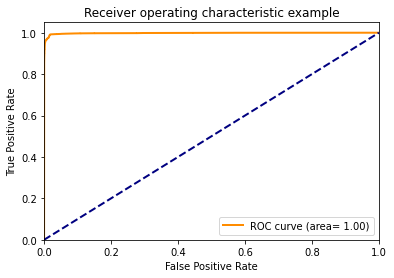

In [17]:
import matplotlib.pyplot as plt

lw=2
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=lw, label ="ROC curve (area= %.2f)"%roc_auc)
plt.plot([0,1],[0,1], color = "navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

# Train multi-class classification

In [18]:
Xtrm = cicids17_m[-1].transform(cicids17_m[0])
Xtem = cicids17_m[-1].transform(cicids17_m[2])
ytrm = cicids17_m[1]
ytem = cicids17_m[3]
train_mulloader = make_dataloader(Xtrm,ytrm.to_numpy().flatten(), batch_size = batch_size, shuffle=True)
test_mulloader = make_dataloader(Xtem,ytem.to_numpy().flatten(), batch_size = batch_size, shuffle=False)

In [21]:
Xbtr = cicids17_m[-1].transform(cicids17_bn[0][ytr_bn==0])
Xbte = cicids17_m[-1].transform(cicids17_bn[2][yte_bn==0])
outlier_trloader = make_dataloader(Xbtr,np.zeros(len(Xbtr)),batch_size=batch_size, shuffle=True)
outlier_teloader = make_dataloader(Xbte,np.zeros(len(Xbte)),batch_size=batch_size, shuffle=True)

In [22]:
num_class = len(np.unique(ytrm))
n_features = Xtrm.shape[1]

In [23]:
clf_mul = MultNN(n_features, n_hidden=32, num_class=num_class)

In [24]:
epochs = 30
criterion_mul = nn.CrossEntropyLoss()
optim_mul = optim.Adam(clf_mul.parameters(),lr=0.0001)

In [25]:
clf_mul = train_model(clf_mul, train_mulloader, optim_mul, device, criterion_mul, epochs, save_dir = result_dir, 
                     save_model = "cicids17_ooc_%s_mul_clf.pth"%(lab_name[ooc_cols]),binary=False)


Epoch [1/30]	Loss 0.7183 (0.4864)	Prec@1 train 84.159 (13.298)   	

Epoch [2/30]	Loss 0.1335 (0.0660)	Prec@1 train 97.605 (1.466)   	

Epoch [3/30]	Loss 0.0648 (0.0473)	Prec@1 train 98.847 (0.659)   	

Epoch [4/30]	Loss 0.0409 (0.0310)	Prec@1 train 99.245 (0.541)   	

Epoch [5/30]	Loss 0.0265 (0.0156)	Prec@1 train 99.448 (0.442)   	

Epoch [6/30]	Loss 0.0191 (0.0129)	Prec@1 train 99.598 (0.388)   	

Epoch [7/30]	Loss 0.0148 (0.0111)	Prec@1 train 99.612 (0.358)   	

Epoch [8/30]	Loss 0.0119 (0.0102)	Prec@1 train 99.636 (0.355)   	

Epoch [9/30]	Loss 0.0097 (0.0094)	Prec@1 train 99.694 (0.326)   	

Epoch [10/30]	Loss 0.0080 (0.0086)	Prec@1 train 99.827 (0.254)   	

Epoch [11/30]	Loss 0.0067 (0.0078)	Prec@1 train 99.877 (0.200)   	

Epoch [12/30]	Loss 0.0057 (0.0074)	Prec@1 train 99.890 (0.185)   	

Epoch [13/30]	Loss 0.0050 (0.0072)	Prec@1 train 99.923 (0.156)   	

Epoch [14/30]	Loss 0.0045 (0.0071)	Prec@1 train 99.936 (0.143)   	

Epoch [15/30]	Loss 0.0040 (0.0068)	Prec@1 train 99.941 

In [26]:
test_model(clf_mul, test_mulloader, criterion_mul, device, 100.0, binary=False)

(tensor(0.0023), tensor(99.9625), tensor(0.1169))

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
pred_m = torch.softmax(get_prediction(clf_mul, test_mulloader, device),dim=1).numpy()
predy_m = np.argmax(pred_m,axis=-1)

In [29]:
confusion_mtx = confusion_matrix(ytem, predy_m)

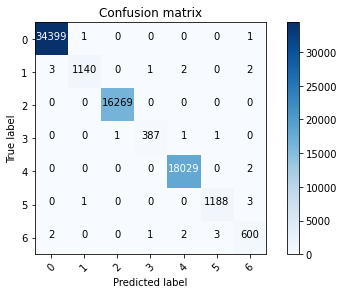

In [30]:
plot_confusion_matrix(confusion_mtx, classes = range(num_class))

# Test OOC

In [56]:
Xoocbn = cicids17_bn[-1].transform(cicids17_m[-2])
ooc_bnloader = make_dataloader(Xoocbn,np.zeros(len(Xoocbn)),batch_size=batch_size, shuffle=True)
Xoocm = cicids17_m[-1].transform(cicids17_m[-2])
ooc_mulloader = make_dataloader(Xoocm,np.zeros(len(Xoocm)),batch_size=batch_size, shuffle=True)

## Benign data

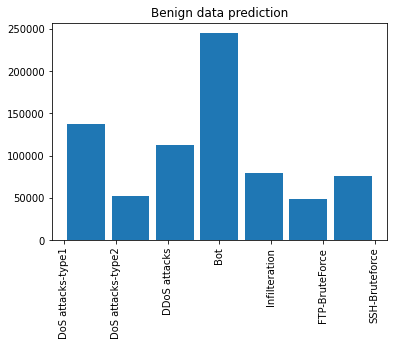

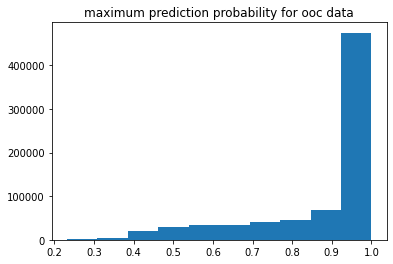

In [60]:
prob_ooc = torch.softmax(get_prediction(clf_mul, outlier_trloader, device), dim=1)
pred_ooc = torch.argmax(prob_ooc, dim=1)

plt.hist(pred_ooc.numpy(), bins=num_class, rwidth=0.85)
plt.title("Benign data prediction")
plt.xticks(range(num_class),lab_name[:ooc_cols]+lab_name[ooc_cols+1:], rotation=90)
plt.show()

plt.hist(np.max(prob_ooc.numpy(),axis=1))
plt.title("maximum prediction probability for ooc data")
plt.show()

## OOC data

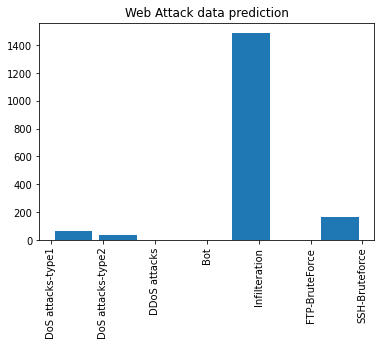

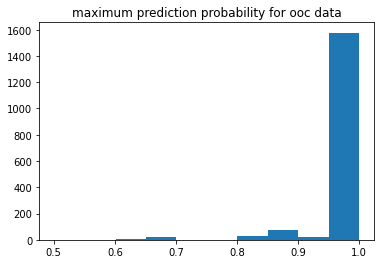

In [59]:
prob_ooc = torch.softmax(get_prediction(clf_mul, ooc_mulloader, device), dim=1)
pred_ooc = torch.argmax(prob_ooc, dim=1)

plt.hist(pred_ooc.numpy(), bins=num_class, rwidth=0.85)
plt.title("%s data prediction"%(lab_name[ooc_cols]))
plt.xticks(range(num_class),lab_name[:ooc_cols]+lab_name[ooc_cols+1:], rotation=90)
plt.show()

plt.hist(np.max(prob_ooc.numpy(),axis=1))
plt.title("maximum prediction probability for ooc data")
plt.show()